In [1]:
import os
import traceback
import random

import pandas as pd
from certa.explain import CertaExplainer
from certa.local_explain import get_original_prediction, get_row
from certa.utils import merge_sources

from baselines.landmark import Landmark
from baselines.mojito import Mojito
import shap
import dice_ml

import pandas as pd
from certa.explain import CertaExplainer
from models.utils import from_type
import numpy as np

import json
import warnings

import nltk
nltk.download('punkt')

warnings.filterwarnings("ignore")
pd.options.display.max_colwidth = 100

from IPython.display import display
from IPython.display import Image

import graphviz
import pydotplus

[nltk_data] Downloading package punkt to /home/tteofili/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import seaborn as sns
cm = sns.light_palette("blue", as_cmap=True)

In [3]:
root_datadir = '../cheapER/datasets/'
experiments_dir = 'examples/'
dataset = 'beers'
datadir = os.path.join(root_datadir, dataset)

In [4]:
lsource = pd.read_csv(datadir + '/tableA.csv')
rsource = pd.read_csv(datadir + '/tableB.csv')
gt = pd.read_csv(datadir + '/train.csv')
valid = pd.read_csv(datadir + '/valid.csv')
test = pd.read_csv(datadir + '/test.csv')

test_df = merge_sources(test, 'ltable_', 'rtable_', lsource, rsource, ['label'], [])
valid_df = merge_sources(valid, 'ltable_', 'rtable_', lsource, rsource, ['label'], [])
train_df = merge_sources(gt, 'ltable_', 'rtable_', lsource, rsource, ['label'], ['id'])

In [5]:
model_type = 'dm'
model = from_type(model_type)
save_path = 'models/saved/' + model_type + '/beers'
model.load(save_path)

In [6]:
def predict_fn(x):
    return model.predict(x)
def predict_fn_mojito(x):
    return model.predict(x, mojito=True)

In [7]:
predictions = model.predict(test_df)
predictions

,label,ltable_ABV,ltable_Beer_Name,ltable_Brew_Factory_Name,ltable_Style,ltable_id,rtable_ABV,rtable_Beer_Name,rtable_Brew_Factory_Name,rtable_Style,rtable_id,nomatch_score,match_score
0,0,8.70 %,Bulleit Bourbon Barrel Aged G'Knight,Oskar Blues Grill & Brew,American Amber / Red Ale,1219.0,-,Figure Eight Bourbon Barrel Aged Jumbo Love,Figure Eight Brewing,Barley Wine,2470.0,0.943249,0.056751
1,0,8.20 %,Double Dragon Imperial Red Ale,Phillips Brewing Company,American Amber / Red Ale,492.0,7.10 %,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale,1635.0,0.975957,0.024043
2,1,7.40 %,Honey Basil Amber,Rude Hippo Brewing Company,American Amber / Red Ale,3917.0,7.40 %,Rude Hippo Honey Basil Amber,18th Street Brewery,Amber Ale,2224.0,0.183886,0.816114
3,0,9.70 %,Clifford 's Big Red Ale,Funky Buddha Brewery,American Amber / Red Ale,2155.0,6.50 %,Big Island Red Giant Ale,Big Island Brewhaus,American Strong Ale,2948.0,0.934337,0.065663
4,1,4.50 %,Real McCoy Amber Ale,Mammoth Brewing Company,American Amber / Red Ale,271.0,4.50 %,Mammoth Real McCoy Amber Ale,Mammoth Brewing Company,Altbier,1410.0,0.501621,0.498379
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0,5.40 %,Mountain City Amber Ale,Tommyknocker Brewery,American Amber / Red Ale,2115.0,5.20 %,Colorado Mountain Ole 59er Amber Ale,Colorado Mountain Brewery,Amber Ale,77.0,0.898074,0.101926
87,1,10.00 %,Thomas Hooker Old Marley Barleywine,Thomas Hooker Brewing Company,American Barleywine,4063.0,10 %,Thomas Hooker Old Marley Barleywine,Thomas Hooker Brewing Company,Barley Wine,2331.0,0.423183,0.576817
88,1,-,Centurion Barleywine Ale,Golden City Brewery,American Barleywine,4161.0,11.20 %,Golden City Centurion Barleywine Ale,Golden City Brewery,Barley Wine,2409.0,0.877802,0.122198
89,1,6.00 %,Red Ale Priprioca,Cervejaria AmazÃ ´ nia Ltda .,American Amber / Red Ale,862.0,6 %,Amazon Beer Priprioca Red Ale,Amazon Beer,Amber Ale,2906.0,0.830464,0.169536


In [8]:
false_positives = predictions.loc[(predictions['label'] == 0) & (predictions['match_score'] > 0.5)]
false_negatives = predictions.loc[(predictions['label'] == 1) & (predictions['match_score'] < 0.5)]
true_positives = predictions.loc[(predictions['label'] == 1) & (predictions['match_score'] > 0.5)]
true_negatives = predictions.loc[(predictions['label'] == 0) & (predictions['match_score'] < 0.5)]

In [9]:
certa_explainer = CertaExplainer(lsource, rsource)

In [10]:
i = 1
rand_row =  test_df.iloc[i]
l_id = int(rand_row['ltable_id'])
label = rand_row["label"]
l_tuple = lsource.iloc[l_id]
r_id = int(rand_row['rtable_id'])
r_tuple = rsource.iloc[r_id]
rand_row.head()

label                                                    0
ltable_ABV                                          8.20 %
ltable_Beer_Name            Double Dragon Imperial Red Ale
ltable_Brew_Factory_Name          Phillips Brewing Company
ltable_Style                      American Amber / Red Ale
Name: 1, dtype: object

In [11]:
label = rand_row['label']
label

0

In [12]:
item = get_row(l_tuple, r_tuple)
n_item = item.drop(['ltable_id','rtable_id'],axis=1)
n_item.reindex(sorted(n_item.columns), axis=1)

,ltable_ABV,ltable_Beer_Name,ltable_Brew_Factory_Name,ltable_Style,rtable_ABV,rtable_Beer_Name,rtable_Brew_Factory_Name,rtable_Style
0,8.20 %,Double Dragon Imperial Red Ale,Phillips Brewing Company,American Amber / Red Ale,7.10 %,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale


In [23]:
saliency_df, pss, counterfactual_examples, triangles, lattices = certa_explainer.explain(l_tuple, r_tuple, predict_fn)

In [25]:
pss.T

ltable_Beer_Name                                          0.083333
ltable_Brew_Factory_Name                                  0.000000
ltable_Style                                              0.000000
ltable_ABV                                                0.000000
rtable_Beer_Name                                          0.166667
rtable_Brew_Factory_Name                                  0.000000
rtable_Style                                              0.000000
rtable_ABV                                                0.000000
ltable_Beer_Name/ltable_Brew_Factory_Name                 0.083333
ltable_Beer_Name/ltable_Style                             0.083333
ltable_Beer_Name/ltable_ABV                               0.500000
ltable_Brew_Factory_Name/ltable_Style                     0.000000
ltable_Brew_Factory_Name/ltable_ABV                       0.000000
ltable_Style/ltable_ABV                                   0.000000
rtable_Beer_Name/rtable_Brew_Factory_Name                 0.16

In [14]:
saliency_df.reindex(sorted(saliency_df.columns), axis=1).style.background_gradient(cmap=cm, axis=1, low=0.1, high=0.6)

,ltable_ABV,ltable_Beer_Name,ltable_Brew_Factory_Name,ltable_Style,rtable_ABV,rtable_Beer_Name,rtable_Brew_Factory_Name,rtable_Style
0,0.508475,0.610169,0.355932,0.355932,0.364407,0.593220,0.364407,0.457627


In [15]:
sdfc = saliency_df.copy()
sdfc.columns=['left_Beer', 'left_ABV', 'left_Factory', 'left_Style', 'right_Beer', 'right_ABV',  'right_Factory', 'right_Style']
sdfc.reindex(sorted(sdfc.columns), axis=1).style.background_gradient(cmap=cm, axis=1, low=0.1, high=0.6)

,left_ABV,left_Beer,left_Factory,left_Style,right_ABV,right_Beer,right_Factory,right_Style
0,0.355932,0.610169,0.355932,0.508475,0.364407,0.593220,0.457627,0.364407


In [16]:
counterfactual_examples

,ltable_Beer_Name,ltable_Brew_Factory_Name,ltable_Style,ltable_ABV,rtable_Beer_Name,rtable_Brew_Factory_Name,rtable_Style,rtable_ABV,nomatch_score,match_score,alteredAttributes,droppedValues,copiedValues,triangle,attr_count
26,Mateo Loco,Phillips Brewing Company,American Amber / Red Ale,10.00 %,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale,7.10 %,0.3467586040496826,0.6532413959503174,"('ltable_Beer_Name', 'ltable_ABV')","['Double Dragon Imperial Red Ale', '8.20 %']","['Mateo Loco', '10.00 %']",0@64021 1@1635 0@492,2
30,Bushwacker,Phillips Brewing Company,American Amber / Red Ale,7.10 %,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale,7.10 %,0.4062122106552124,0.5937877893447876,"('ltable_Beer_Name', 'ltable_ABV')","['Double Dragon Imperial Red Ale', '8.20 %']","['Bushwacker', '7.10 %']",0@23950 1@1635 0@492,2
35,Oho-Rojo,Phillips Brewing Company,American Amber / Red Ale,6.10 %,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale,7.10 %,0.2519966959953308,0.7480033040046692,"('ltable_Beer_Name', 'ltable_ABV')","['Double Dragon Imperial Red Ale', '8.20 %']","['Oho-Rojo', '6.10 %']",0@80327 1@1635 0@492,2
36,First,Phillips Brewing Company,American Amber / Red Ale,5.10 %,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale,7.10 %,0.3203560709953308,0.6796439290046692,"('ltable_Beer_Name', 'ltable_ABV')","['Double Dragon Imperial Red Ale', '8.20 %']","['First', '5.10 %']",0@78172 1@1635 0@492,2
39,IRA,Phillips Brewing Company,American Amber / Red Ale,7.10 %,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale,7.10 %,0.39360278844833374,0.6063972115516663,"('ltable_Beer_Name', 'ltable_ABV')","['Double Dragon Imperial Red Ale', '8.20 %']","['IRA', '7.10 %']",0@23567 1@1635 0@492,2
40,Scuttlebutt Amber,Phillips Brewing Company,American Amber / Red Ale,5.10 %,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale,7.10 %,0.39407283067703247,0.6059271693229675,"('ltable_Beer_Name', 'ltable_ABV')","['Double Dragon Imperial Red Ale', '8.20 %']","['Scuttlebutt Amber', '5.10 %']",0@8690 1@1635 0@492,2
32,Ending,Phillips Brewing Company,American Amber / Red Ale,5.10 %,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale,7.10 %,0.333637535572052,0.666362464427948,"('ltable_Beer_Name', 'ltable_ABV')","['Double Dragon Imperial Red Ale', '8.20 %']","['Ending', '5.10 %']",0@61507 1@1635 0@492,2
13,Shuffle,Phillips Brewing Company,American Amber / Red Ale,5.10 %,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale,7.10 %,0.3127260208129883,0.6872739791870117,"('ltable_Beer_Name', 'ltable_ABV')","['Double Dragon Imperial Red Ale', '8.20 %']","['Shuffle', '5.10 %']",0@68725 1@1635 0@492,2
17,Panama,Phillips Brewing Company,American Amber / Red Ale,6.10 %,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale,7.10 %,0.3153000473976135,0.6846999526023865,"('ltable_Beer_Name', 'ltable_ABV')","['Double Dragon Imperial Red Ale', '8.20 %']","['Panama', '6.10 %']",0@51520 1@1635 0@492,2
18,Moore,Phillips Brewing Company,American Amber / Red Ale,6.10 %,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale,7.10 %,0.290488064289093,0.709511935710907,"('ltable_Beer_Name', 'ltable_ABV')","['Double Dragon Imperial Red Ale', '8.20 %']","['Moore', '6.10 %']",0@70300 1@1635 0@492,2


In [72]:
pss_df = pd.DataFrame(pss).T

In [79]:
pss_df.columns = ['left_Beer', 'left_Factory', 'left_Style',
       'left_ABV', 'right_Beer', 'right_Factory',
       'right_Style', 'right_ABV',
       'left_Beer, left_Factory',
       'left_Beer, left_Style', 'left_Beer, left_ABV',
       'left_Factory, left_Style',
       'left_Factory, left_ABV', 'left_Style, left_ABV',
       'right_Beer, right_Factory',
       'right_Beer, right_Style', 'right_Beer, right_ABV',
       'right_Factory, right_Style',
       'right_Factory, right_ABV', 'right_Style, right_ABV',
       'left_Beer, left_Factory, left_Style',
       'left_Beer, left_Factory, left_ABV',
       'left_Beer, left_Style, left_ABV',
       'left_Factory_Name, left_Style, left_ABV',
       'right_Beer, right_Factory, right_Style',
       'right_Beer, right_Factory, right_ABV',
       'right_Beer, right_Style, right_ABV',
       'right_Factory, right_Style, right_ABV']

In [83]:

pss_sorted = pss_df.T[pss_df.T > 0].dropna().T
pss_sorted.reindex(sorted(pss_sorted.columns), axis=1).style.background_gradient(cmap=cm, axis=None, low=0.1, high=0.6)

,left_Beer,"left_Beer, left_ABV","left_Beer, left_Factory","left_Beer, left_Factory, left_ABV","left_Beer, left_Factory, left_Style","left_Beer, left_Style","left_Beer, left_Style, left_ABV",right_Beer,"right_Beer, right_ABV","right_Beer, right_Factory","right_Beer, right_Factory, right_ABV","right_Beer, right_Factory, right_Style","right_Beer, right_Style","right_Beer, right_Style, right_ABV"
0,0.083333,0.500000,0.083333,0.500000,0.083333,0.083333,0.500000,0.166667,0.125000,0.166667,0.208333,0.416667,0.375000,0.458333


In [18]:
lattice = lattices[3]
lattice.triangle

,id,Beer_Name,Brew_Factory_Name,Style,ABV,type
1635,1635,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale,7.10 %,pivot
492,492,Double Dragon Imperial Red Ale,Phillips Brewing Company,American Amber / Red Ale,8.20 %,free
2927,61507,Ending,Scuttlebutt Brewing Company,American Amber / Red Ale,5.10 %,support


In [19]:
ldf = lattice.triangle.copy()
ldf.columns=['id','Beer','Factory','Style','ABV','type']
ldf.at[492,'Beer'] = 'Mateo Loco'
ldf

,id,Beer,Factory,Style,ABV,type
1635,1635,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale,7.10 %,pivot
492,492,Mateo Loco,Phillips Brewing Company,American Amber / Red Ale,8.20 %,free
2927,61507,Ending,Scuttlebutt Brewing Company,American Amber / Red Ale,5.10 %,support


In [20]:
def show_lattice(lattice, depth=-1):
    dot_data = lattice.hasse(depth=depth) 
    graph = graphviz.Source(dot_data)
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    return Image(pydot_graph.create_png())

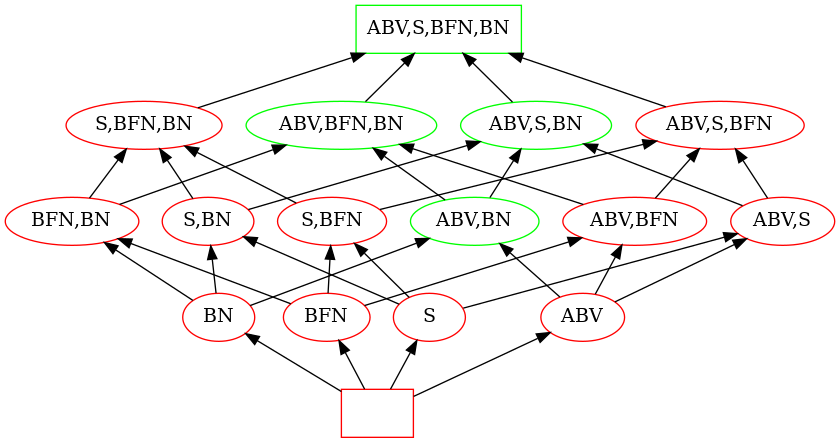

In [21]:
show_lattice(lattice)

In [22]:
lattice.hasse()

'digraph G {\nsplines="line"\nrankdir=BT\n"ABV,S,BFN,BN" [shape=box];\n"" [shape=box];\n"" [color=red];\n"" -> "BN";\n"" -> "BFN";\n"" -> "S";\n"" -> "ABV";\n"BN" [color=red];\n"BN" -> "BFN,BN";\n"BN" -> "S,BN";\n"BN" -> "ABV,BN";\n"BFN" [color=red];\n"BFN" -> "BFN,BN";\n"BFN" -> "S,BFN";\n"BFN" -> "ABV,BFN";\n"S" [color=red];\n"S" -> "S,BN";\n"S" -> "S,BFN";\n"S" -> "ABV,S";\n"ABV" [color=red];\n"ABV" -> "ABV,BN";\n"ABV" -> "ABV,BFN";\n"ABV" -> "ABV,S";\n"BFN,BN" [color=red];\n"BFN,BN" -> "S,BFN,BN";\n"BFN,BN" -> "ABV,BFN,BN";\n"S,BN" [color=red];\n"S,BN" -> "S,BFN,BN";\n"S,BN" -> "ABV,S,BN";\n"ABV,BN" [color=green];\n"ABV,BN" -> "ABV,BFN,BN";\n"ABV,BN" -> "ABV,S,BN";\n"S,BFN" [color=red];\n"S,BFN" -> "S,BFN,BN";\n"S,BFN" -> "ABV,S,BFN";\n"ABV,BFN" [color=red];\n"ABV,BFN" -> "ABV,BFN,BN";\n"ABV,BFN" -> "ABV,S,BFN";\n"ABV,S" [color=red];\n"ABV,S" -> "ABV,S,BN";\n"ABV,S" -> "ABV,S,BFN";\n"S,BFN,BN" [color=red];\n"S,BFN,BN" -> "ABV,S,BFN,BN";\n"ABV,BFN,BN" [color=green];\n"ABV,BFN,BN" ->